### Step 1: Setup and Data Ingestion
This cell only handles the API connection, downloading, and fixing the structure of the dataframe.

In [3]:
import yfinance as yf
import pandas as pd
import time

# 1. Configuration
ticker_symbol = "RSP"
start_date = "2003-05-01"

print(f"--- Step 1: Ingesting data for {ticker_symbol} ---")
start_time = time.time()

# 2. Download raw data
# We download everything available to have a clean starting point
raw_data = yf.download(ticker_symbol, start=start_date, progress=True)

# 3. Structural Fix: Flatten MultiIndex columns if present (common in new yfinance versions)
if isinstance(raw_data.columns, pd.MultiIndex):
    raw_data.columns = raw_data.columns.get_level_values(0)

end_time = time.time()
print(f"Download completed in {end_time - start_time:.2f} seconds.")
print(f"Initial Dataset Shape: {raw_data.shape}")

# Inspect the raw structure
raw_data.head()

--- Step 1: Ingesting data for RSP ---


[*********************100%***********************]  1 of 1 completed

Download completed in 0.81 seconds.
Initial Dataset Shape: (5705, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2003-05-01,17.983393,18.048639,17.752383,17.810577,157200
2003-05-02,18.318441,18.318441,17.963994,17.963994,61200
2003-05-05,18.357244,18.436599,18.293761,18.353718,140000
2003-05-06,18.503605,18.588250,18.374874,18.374874,30000
2003-05-07,18.431301,18.563558,18.339604,18.392507,20800


### Step 2: Data Validation and Target Creation
Now that we are sure the data is in the right format, we create our "Target" (what we want to predict).

In [4]:
# 1. Create a working copy to preserve raw data
data = raw_data.copy()

# 2. Create the Target variable (The "Ground Truth")
# We shift the Close price back by 1 day to see tomorrow's result today
data["Tomorrow"] = data["Close"].shift(-1)

# Target: 1 if price goes UP tomorrow, 0 if it stays the same or goes DOWN
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

# 3. Clean incomplete rows
# The very last row will always have a NaN in 'Tomorrow' because tomorrow hasn't happened yet
data = data.dropna()

print("--- Step 2: Data Validation ---")
print(f"Processed Dataset Shape: {data.shape}")
print(f"Target distribution (0=Down/Flat, 1=Up):\n{data['Target'].value_counts(normalize=True)}")

data.head()

--- Step 2: Data Validation ---
Processed Dataset Shape: (5704, 7)
Target distribution (0=Down/Flat, 1=Up):
Target
1    0.546108
0    0.453892
Name: proportion, dtype: float64


Price,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2003-05-01,17.983393,18.048639,17.752383,17.810577,157200,18.318441,1
2003-05-02,18.318441,18.318441,17.963994,17.963994,61200,18.357244,1
2003-05-05,18.357244,18.436599,18.293761,18.353718,140000,18.503605,1
2003-05-06,18.503605,18.588250,18.374874,18.374874,30000,18.431301,0
2003-05-07,18.431301,18.563558,18.339604,18.392507,20800,18.232033,0


### Step 2.5: Visual EDA (Your Visualization Code)
Keep this code exactly as you have it, but let's add one small fix: ensure it uses the data variable from the previous cell.

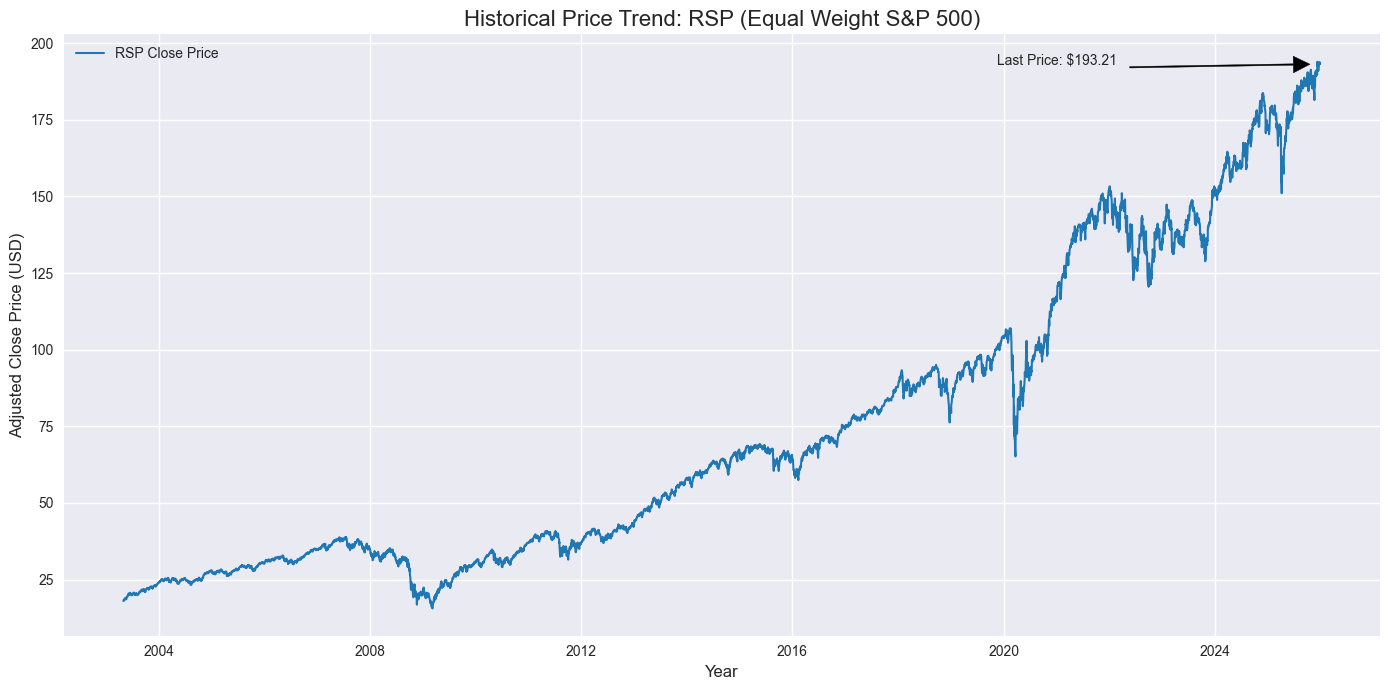

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 2.5: Visual Exploratory Data Analysis ---

# Use 'ggplot' or 'seaborn-v0_8' (if available), otherwise fallback to 'bmh'
available_styles = plt.style.available
if 'seaborn-v0_8' in available_styles:
    plt.style.use('seaborn-v0_8')
elif 'ggplot' in available_styles:
    plt.style.use('ggplot')
else:
    plt.style.use('bmh')

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], color='#1f77b4', linewidth=1.5, label='RSP Close Price')

# Enhance chart with metadata
plt.title(f'Historical Price Trend: {ticker_symbol} (Equal Weight S&P 500)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adjusted Close Price (USD)', fontsize=12)

# Highlight key info
plt.legend(loc='upper left')

# Dynamic annotation for the last available price
last_date = data.index[-1]
last_price = float(data["Close"].iloc[-1])

plt.annotate(f'Last Price: ${last_price:.2f}', 
             xy=(last_date, last_price),
             xytext=(0.8, 0.95), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             horizontalalignment='right')

plt.tight_layout()
plt.show()

### Step 3: Technical Indicators & Feature Engineering
In this cell, we will calculate rolling averages and price ratios. This allows the model to compare the current price to its historical performance over different time horizons.

In [7]:
import numpy as np
from tqdm.auto import tqdm

print("--- Step 3: Feature Engineering (Technical Indicators) ---")

# 1. Define time horizons (trading days)
# 2: Ultra short-term
# 5: One trading week
# 60: One trading quarter
# 250: One trading year
# 1000: Long-term trend (~4 years)
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

# 2. Loop through horizons with a progress bar
for horizon in tqdm(horizons, desc="Generating Technical Features"):
    # Calculate Rolling Average
    rolling_averages = data["Close"].rolling(horizon).mean()
    
    # Feature 1: Close Price Ratio
    # (Today's Close / Average Close of the period)
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages
    
    # Feature 2: Trend
    # (Sum of positive days in the last 'X' days)
    # We shift(1) to ensure we only use PAST data to predict the future
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data["Target"].shift(1).rolling(horizon).sum()
    
    new_predictors += [ratio_column, trend_column]

# 3. Final Cleaning
# Rolling windows create NaN values at the beginning of the dataset
# (e.g., the 1000-day window needs 1000 days of data before it can calculate a value)
data_prepared = data.dropna().copy()

print(f"Feature Engineering Complete.")
print(f"Final Dataset Shape: {data_prepared.shape}")
print(f"Predictors created: {new_predictors}")

# Show the last 5 rows of the new features
data_prepared[new_predictors].tail()

c:\Users\gabri_7a484pu\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Step 3: Feature Engineering (Technical Indicators) ---


Generating Technical Features: 100%|██████████| 5/5 [00:00<00:00, 620.11it/s]

Feature Engineering Complete.
Final Dataset Shape: (4704, 17)
Predictors created: ['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']


Price,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,
2025-12-23,0.998836,1.0,1.004448,3.0,1.022619,35.0,1.074950,130.0,1.242806,520.0
2025-12-24,1.001809,1.0,1.005182,4.0,1.025888,35.0,1.078386,130.0,1.246976,521.0
2025-12-26,1.000129,2.0,1.002922,4.0,1.025749,35.0,1.078209,130.0,1.246961,522.0
2025-12-29,0.999174,1.0,0.999814,3.0,1.023722,34.0,1.075954,130.0,1.244571,521.0
2025-12-30,0.999198,0.0,0.998553,2.0,1.021837,33.0,1.073722,130.0,1.242259,520.0


### Step 4: Baseline Model Training (Random Forest)
Place this cell before the ETL cell. This establishes your starting point (Baseline).

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

print("--- Step 4: Training Baseline Model (RSP Only) ---")

# 1. Define predictors (using only the ones from Step 3 for now)
# We exclude 'Target' and 'Tomorrow' to avoid data leakage
predictors = ["Close_Ratio_2", "Trend_2", "Close_Ratio_5", "Trend_5", 
              "Close_Ratio_60", "Trend_60", "Close_Ratio_250", "Trend_250", 
              "Close_Ratio_1000", "Trend_1000"]

# 2. Initialize Random Forest
# We use min_samples_split=50 to prevent the model from over-fitting to noise
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# 3. Time-Series Split
# Train on all data except the last 100 days
# Test on the most recent 100 days
train = data_prepared.iloc[:-100]
test = data_prepared.iloc[-100:]

# 4. Train the model
model.fit(train[predictors], train["Target"])

# 5. Evaluate
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision = precision_score(test["Target"], preds)

print(f"Baseline Training Complete.")
print(f"Initial Precision Score: {precision:.2%}")

--- Step 4: Training Baseline Model (RSP Only) ---
Baseline Training Complete.
Initial Precision Score: 53.57%


### Step 5: ETL Process (Integrating Multiple Sources)
We will add the VIX index. When the VIX is high, the market is panicking; when it's low, the market is calm. This is a powerful predictor for stock trends.

In [8]:
import yfinance as yf
import pandas as pd
from tqdm.auto import tqdm

print("--- Step 5: ETL (Extract, Transform, Load) ---")

# 1. EXTRACT: Fetch secondary data (VIX - Volatility Index)
# VIX measures market risk and sentiment
vix_ticker = "^VIX"
print(f"Extracting external data: {vix_ticker}...")
vix_data = yf.download(vix_ticker, start="2003-05-01", progress=False)

# Flatten columns if necessary (consistency fix)
if isinstance(vix_data.columns, pd.MultiIndex):
    vix_data.columns = vix_data.columns.get_level_values(0)

# 2. TRANSFORM: Align and Join datasets
# We only need the 'Close' price of VIX to represent daily fear levels
vix_close = vix_data[['Close']].rename(columns={'Close': 'VIX_Close'})

# Merge with our existing data_prepared dataframe
# This is the "Integration" part of ETL
data_final = data_prepared.merge(vix_close, left_index=True, right_index=True, how='left')

# 3. TRANSFORM: Handle missing values and create VIX features
# If VIX is missing for a specific day, we forward-fill it
data_final['VIX_Close'] = data_final['VIX_Close'].ffill()

# Create a 'Fear Ratio' (Is volatility increasing or decreasing?)
data_final['VIX_Ratio'] = data_final['VIX_Close'] / data_final['VIX_Close'].rolling(5).mean()

# 4. LOAD: Save the final integrated dataset for modeling
# We drop the few NaNs created by the VIX rolling mean
data_final = data_final.dropna()

# Update our predictors list to include the new source
new_predictors += ['VIX_Close', 'VIX_Ratio']

print(f"ETL Complete.")
print(f"Final Integrated Shape: {data_final.shape}")
print(f"Integrated Features: {['VIX_Close', 'VIX_Ratio']}")

# Export the clean dataset to a CSV file (The "Load" part)
data_final.to_csv("../data/processed_market_data.csv")
print("Transformed dataset loaded to: ../data/processed_market_data.csv")

data_final[['Close', 'VIX_Close', 'VIX_Ratio']].tail()

--- Step 5: ETL (Extract, Transform, Load) ---
Extracting external data: ^VIX...
ETL Complete.
Final Integrated Shape: (4700, 19)
Integrated Features: ['VIX_Close', 'VIX_Ratio']
Transformed dataset loaded to: ../data/processed_market_data.csv


Price,Close,VIX_Close,VIX_Ratio
Date,,,
2025-12-23,193.089996,14.00,0.903459
2025-12-24,193.789993,13.47,0.918451
2025-12-26,193.839996,13.60,0.970597
2025-12-29,193.520004,14.20,1.023792
2025-12-30,193.210007,14.33,1.029454


### Step 6: Improved Model Training (RSP + VIX)
In this cell, we include the new features extracted and transformed in Step 5.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

print("--- Step 6: Training Improved Model (RSP + VIX) ---")

# 1. Update predictors to include our ETL results
# We add VIX_Close and VIX_Ratio to the original list
improved_predictors = predictors + ["VIX_Close", "VIX_Ratio"]

# 2. Initialize the model 
# (Keeping parameters the same as Step 4 for a fair comparison)
improved_model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# 3. Time-Series Split using the data_final (Integrated Dataset)
train_final = data_final.iloc[:-100]
test_final = data_final.iloc[-100:]

# 4. Train the improved model
improved_model.fit(train_final[improved_predictors], train_final["Target"])

# 5. Evaluate
final_preds = improved_model.predict(test_final[improved_predictors])
final_preds = pd.Series(final_preds, index=test_final.index)
final_precision = precision_score(test_final["Target"], final_preds)

print(f"Improved Training Complete.")
print(f"New Precision Score: {final_precision:.2%}")

# 6. Compare Results
improvement = final_precision - precision # 'precision' comes from Step 4
print(f"Precision Improvement: {improvement:+.2%}")

--- Step 6: Training Improved Model (RSP + VIX) ---
Improved Training Complete.
New Precision Score: 51.39%
Precision Improvement: -2.18%


### Step 7: Feature Engineering (Split & Scale)
This step implements a chronological train-validation-test split and applies feature scaling. It is crucial to fit the scaler only on the training data to prevent data leakage.

In [11]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

print("--- Step 7: Feature Engineering (Split & Scale) ---")

# 1. Define Final Predictors (RSP + VIX)
predictors = ["Close_Ratio_2", "Trend_2", "Close_Ratio_5", "Trend_5", 
              "Close_Ratio_60", "Trend_60", "Close_Ratio_250", "Trend_250", 
              "Close_Ratio_1000", "Trend_1000", "VIX_Close", "VIX_Ratio"]

# 2. Chronological Train-Validation-Test Split
# We will use: 
# - 80% for Training
# - 10% for Validation (Parameter tuning)
# - 10% for Testing (Final "blind" evaluation)

n = len(data_final)
train_df = data_final.iloc[0 : int(n*0.8)]
val_df = data_final.iloc[int(n*0.8) : int(n*0.9)]
test_df = data_final.iloc[int(n*0.9) :]

# 3. Transformation: Scaling (Standardization)
# It is vital to fit the scaler ONLY on the training data
scaler = StandardScaler()
scaler.fit(train_df[predictors])

# Apply transformation to all three sets
train_scaled = scaler.transform(train_df[predictors])
val_scaled = scaler.transform(val_df[predictors])
test_scaled = scaler.transform(test_df[predictors])

# Convert back to DataFrames to maintain consistency and index
train_scaled_df = pd.DataFrame(train_scaled, columns=predictors, index=train_df.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=predictors, index=val_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=predictors, index=test_df.index)

print(f"Splitting complete:")
print(f"- Train set: {train_scaled_df.shape[0]} rows")
print(f"- Validation set: {val_scaled_df.shape[0]} rows")
print(f"- Test set: {test_scaled_df.shape[0]} rows")

--- Step 7: Feature Engineering (Split & Scale) ---
Splitting complete:
- Train set: 3760 rows
- Validation set: 470 rows
- Test set: 470 rows


### Step 8: Advanced Feature Engineering (PCA)
We will apply PCA to our scaled data. This addresses the "dimensionality reduction" part of your Kanban hint.

--- Step 8: Dimensionality Reduction (PCA) ---


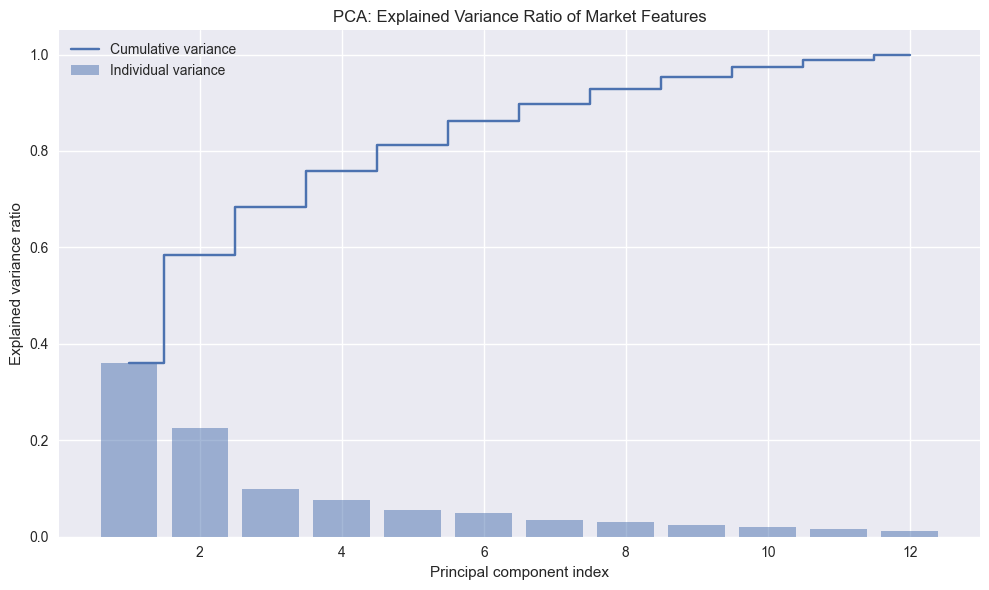

Original number of features: 12
Reduced number of features (95% variance): 9


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

print("--- Step 8: Dimensionality Reduction (PCA) ---")

# 1. Initialize PCA
# We start by looking at how many components explain most of the variance
pca = PCA(n_components=None)
pca.fit(train_scaled_df)

# 2. Calculate Explained Variance Ratio
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# 3. Visualize Explained Variance to find the "Elbow"
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(exp_var_pca) + 1), exp_var_pca, alpha=0.5, align='center', label='Individual variance')
plt.step(range(1, len(cum_sum_eigenvalues) + 1), cum_sum_eigenvalues, where='mid', label='Cumulative variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA: Explained Variance Ratio of Market Features')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 4. Apply PCA transformation
# We choose to keep components that explain 95% of the variance
pca_95 = PCA(n_components=0.95)
train_pca = pca_95.fit_transform(train_scaled_df)
val_pca = pca_95.transform(val_scaled_df)
test_pca = pca_95.transform(test_scaled_df)

print(f"Original number of features: {train_scaled_df.shape[1]}")
print(f"Reduced number of features (95% variance): {train_pca.shape[1]}")

### Step 9: Model Training with Engineered Features
In this cell, we train the Random Forest using the PCA-transformed data. We use the Validation Set for evaluation, as per the Kanban requirement to use a three-way split.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

print("--- Step 9: Training with Scaled PCA Features ---")

# 1. Initialize the model
# We keep the same parameters to see the impact of Feature Engineering specifically
pca_model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# 2. Train on the PCA-transformed Training Set
# Target is the same as before
pca_model.fit(train_pca, train_df["Target"])

# 3. Predict on the PCA-transformed Validation Set
val_preds = pca_model.predict(val_pca)
val_preds = pd.Series(val_preds, index=val_df.index)

# 4. Evaluate Precision
pca_precision = precision_score(val_df["Target"], val_preds)

print(f"PCA Model Training Complete.")
print(f"Validation Precision Score: {pca_precision:.2%}")

# 5. Compare with previous Baseline
# Note: Baseline was 53.57% on a different split, so we look for stability above 50%

--- Step 9: Training with Scaled PCA Features ---
PCA Model Training Complete.
Validation Precision Score: 52.10%


### Step 10: Machine Learning Workflow - Hyperparameter Tuning
We will iterate through different configurations of the Random Forest model using our Validation Set. This ensures we are not just "guessing" but using a data-driven approach to optimize performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

print("--- Step 10: ML Workflow - Hyperparameter Tuning ---")

# 1. Define the search space for our 'experimentation' phase
# We test different tree counts and depths to find the best fit
n_estimators_options = [100, 200, 500]
max_depth_options = [5, 10, 15]
min_samples_split_options = [25, 50, 100]

best_precision = 0
best_params = {}

# 2. Iterate and Evaluate (The "Workflow" loop)
# We use the PCA-transformed training data and validate on the validation set
for n_est in n_estimators_options:
    for depth in max_depth_options:
        for split in min_samples_split_options:
            # Build the model variant
            model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                min_samples_split=split,
                random_state=1,
                n_jobs=-1
            )
            
            # Train the model
            model.fit(train_pca, train_df["Target"])
            
            # Evaluate on the Validation Set
            preds = model.predict(val_pca)
            precision = precision_score(val_df["Target"], preds)
            
            # Track the best performing model
            if precision > best_precision:
                best_precision = precision
                best_params = {
                    'n_estimators': n_est,
                    'max_depth': depth,
                    'min_samples_split': split
                }

print(f"Hyperparameter Tuning Complete.")
print(f"Best Parameters: {best_params}")
print(f"Top Validation Precision: {best_precision:.2%}")

--- Step 10: ML Workflow - Hyperparameter Tuning ---
